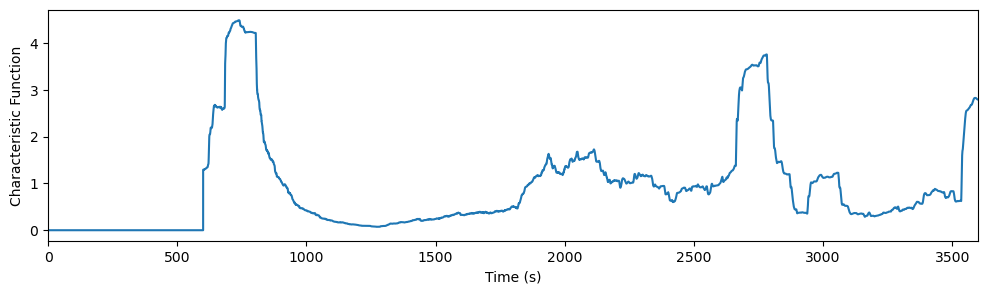

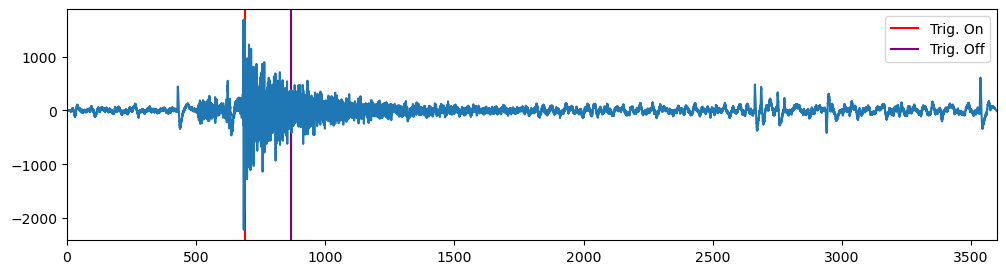

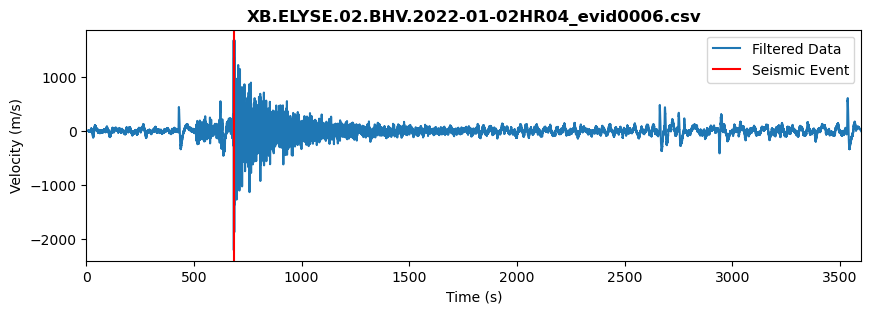

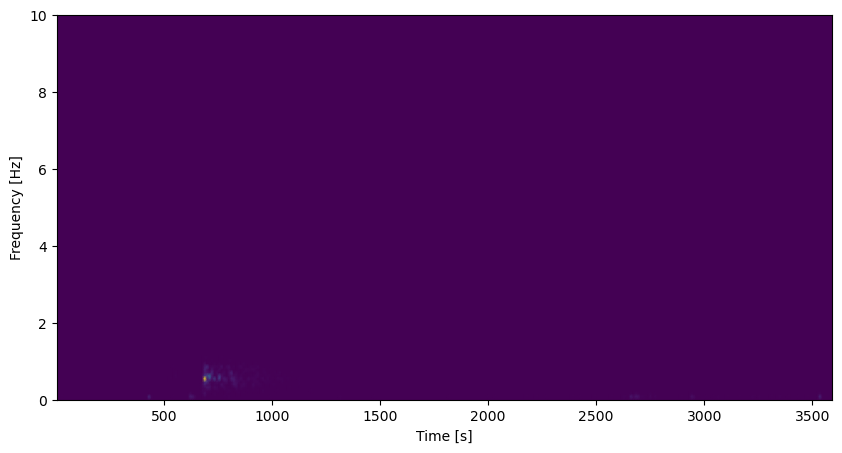

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from obspy.core import UTCDateTime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Function to filter the seismic data to remove noise (e.g., high-pass filter)
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Read in the catalog (for training data with labeled events)
cat_directory = r'C:\Users\R Durga Bhavani\Downloads\seismic_extracted\space_apps_2024_seismic_detection\data\mars\training\catalogs\Mars_InSight_training_catalog_final.csv'
cat_file = cat_directory 
cat = pd.read_csv(cat_file)

# Select a seismic event from the catalog
row = cat.iloc[1]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel = row['time_rel(sec)']
test_filename = row.filename

# Read the MiniSEED file corresponding to that detection
test_filenames_mseed = [
   "XB.ELYSE.02.BHV.2022-01-02HR04_evid0006",
   "XB.ELYSE.02.BHV.2022-02-03HR08_evid0005",
]

# Directory containing the MiniSEED files
data_directory = r'C:\Users\R Durga Bhavani\Downloads\seismic_extracted\space_apps_2024_seismic_detection\data\mars\training\data'

# Loop through the test filenames
for filename in test_filenames_mseed:
    mseed_file = f'{data_directory}\\{filename}.mseed'
    
    # Read the MiniSEED file

st = read(mseed_file)
    


# Extract trace data
tr = st[0].copy()
tr_times = tr.times()
tr_data = tr.data
fs = tr.stats.sampling_rate  # Sampling frequency

# Apply bandpass filter (to handle planetary-specific noise and anomalies)
lowcut = 0.01  # Adjust to target specific seismic frequencies
highcut = 1.0
tr_data_filt = bandpass_filter(tr_data, lowcut, highcut, fs)

# Function to handle missing data
def handle_missing_data(data):
    data = np.nan_to_num(data)  # Replace NaN with zeros or mean of neighbors
    return data

tr_data_filt = handle_missing_data(tr_data_filt)

# Apply Short-Term Average / Long-Term Average (STA/LTA) algorithm
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = fs  # Sampling frequency
cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))

# Plot characteristic function for STA/LTA
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(tr_times, cft)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic Function')

# Define trigger thresholds and identify seismic events
thr_on = 4  # On threshold
thr_off = 1.5  # Off threshold
on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Plot triggers
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
for i in range(len(on_off)):
    triggers = on_off[i]
    ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot filtered trace with marked detections
ax.plot(tr_times, tr_data_filt)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.legend()

# Convert time to absolute
starttime = tr.stats.starttime.datetime
detection_times = []
fnames = []
for i in range(len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds=tr_times[triggers[0]])
    detection_times.append(on_time)
    fnames.append(test_filename)

# Compile detected events into a DataFrame and export to CSV
detect_df = pd.DataFrame({
    'filename': fnames, 
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
    'time_rel(sec)': tr_times[on_off[:, 0]]
})

detect_df.to_csv('output/d_catalog.csv', index=False)

# Optional: Machine Learning Approach (If Applicable)
# You could add a section here using libraries such as scikit-learn or TensorFlow
# to train a machine learning model for automatic detection using seismic data
# from both Earth and planetary datasets.

# Visualization of Seismic Data (Creativity)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(tr_times, tr_data_filt, label='Filtered Data')
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Mark event detections on the plot
for trigger in on_off:
    ax.axvline(x=tr_times[trigger[0]], color='red', label='Seismic Event')

plt.legend()
plt.show()

# Optional: Spectrogram visualization for additional data representation
from scipy import signal
f, t, Sxx = signal.spectrogram(tr_data_filt, fs)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(t, f, Sxx, shading='gouraud')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
plt.show()


In [2]:
import os  # Add this import at the top of your script

# Define the output directory
output_directory = 'output'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Compile detected events into a DataFrame and export to CSV
detect_df = pd.DataFrame({
    'filename': fnames, 
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
    'time_rel(sec)': tr_times[on_off[:, 0]]
})

# Save to CSV in the output directory
detect_df.to_csv(f'{output_directory}/d_catalog.csv', index=False)


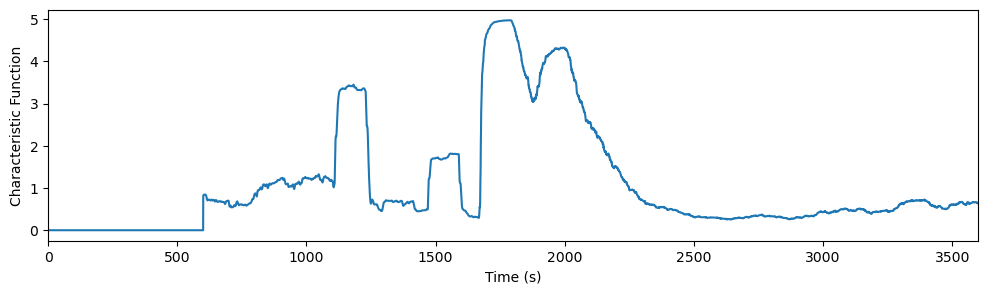

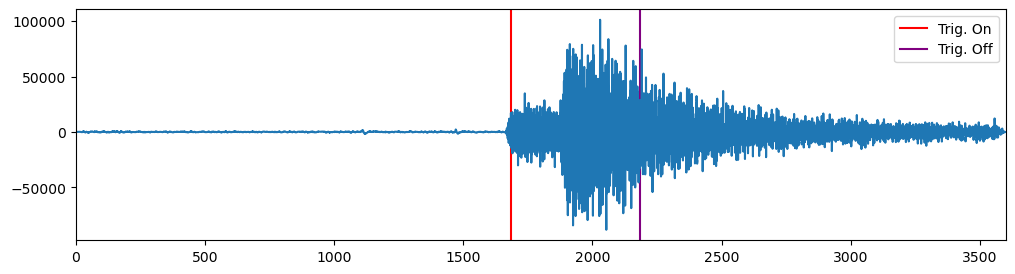

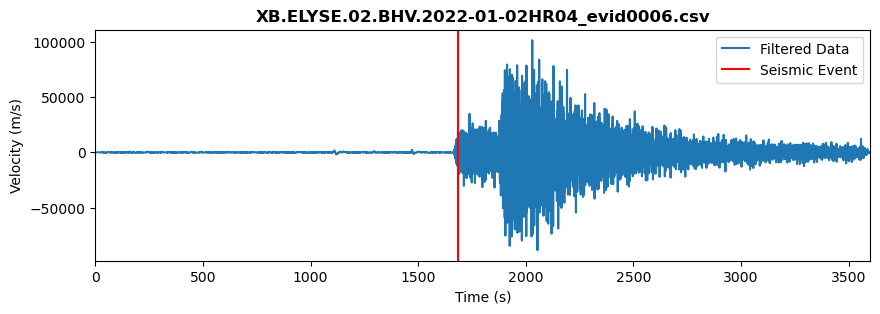

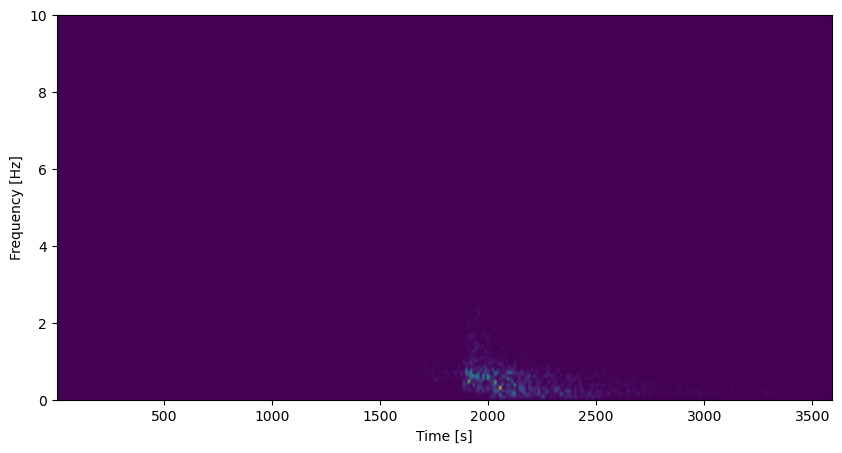

In [4]:
import numpy as np
import pandas as pd
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from obspy.core import UTCDateTime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Example usage for reading a catalog
# cat_directory = r'C:\Users\R Durga Bhavani\Downloads\space_apps_2024_seismic_detection\space_apps_2024_seismic_detection\data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv'
# cat_file = cat_directory 
# cat = pd.read_csv(cat_file)

# Select a seismic event from the catalog
# row = cat.iloc[6]
# arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
# arrival_time_rel = row['time_rel(sec)']
# test_filename = row.filename

test_filenames_mseed = [
    "XB.ELYSE.02.BHV.2019-05-23HR02_evid0041",
    "XB.ELYSE.02.BHV.2019-07-26HR12_evid0033",
    "XB.ELYSE.02.BHV.2019-07-26HR12_evid0034",
    "XB.ELYSE.02.BHV.2019-09-21HR03_evid0032",
    "XB.ELYSE.02.BHV.2021-05-02HR01_evid0017",
    "XB.ELYSE.02.BHV.2021-10-11HR23_evid0011",
    "XB.ELYSE.02.BHV.2021-12-24HR22_evid0007",
    "XB.ELYSE.02.BHV.2022-04-09HR22_evid0002",
    "XB.ELYSE.02.BHV.2022-05-04HR23_evid0001",
]

# Directory containing the MiniSEED files
data_directory = r'C:\Users\R Durga Bhavani\Downloads\seismic_extracted\space_apps_2024_seismic_detection\data\mars\test\data'

# Loop through the test filenames
for filename in test_filenames_mseed:
    mseed_file = f'{data_directory}\\{filename}.mseed'
    
    # Read the MiniSEED file
    try:
        st = read(mseed_file)
    except Exception as e:
        print(f"Error reading {mseed_file}: {e}")
        continue  # Skip this file and continue with the next one

    # Extract trace data
    tr = st[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    fs = tr.stats.sampling_rate  # Sampling frequency

    # Apply bandpass filter (to handle planetary-specific noise and anomalies)
    lowcut = 0.01  # Adjust to target specific seismic frequencies
    highcut = 1.0
    tr_data_filt = bandpass_filter(tr_data, lowcut, highcut, fs)

    # Handle missing data after filtering
    tr_data_filt = handle_missing_data(tr_data_filt)

# Function to handle missing data
def handle_missing_data(data):
    data = np.nan_to_num(data)  # Replace NaN with zeros
    return data


tr_data_filt = handle_missing_data(tr_data_filt)

# Apply Short-Term Average / Long-Term Average (STA/LTA) algorithm
sta_len = 120  # Short-term window in seconds
lta_len = 600  # Long-term window in seconds
df = fs  # Sampling frequency
cft = classic_sta_lta(tr_data_filt, int(sta_len * df), int(lta_len * df))

# Plot characteristic function for STA/LTA
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(tr_times, cft)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic Function')

# Define trigger thresholds and identify seismic events
thr_on = 4  # On threshold
thr_off = 1.5  # Off threshold
on_off = np.array(trigger_onset(cft, thr_on, thr_off))

# Plot triggers
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
for i in range(len(on_off)):
    triggers = on_off[i]
    ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot filtered trace with marked detections
ax.plot(tr_times, tr_data_filt)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.legend()

# Convert time to absolute
starttime = tr.stats.starttime.datetime
detection_times = []
fnames = []
for i in range(len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds=tr_times[triggers[0]])
    detection_times.append(on_time)
    fnames.append(test_filename)

# Compile detected events into a DataFrame and export to CSV
detect_df = pd.DataFrame({
    'filename': fnames, 
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
    'time_rel(sec)': tr_times[on_off[:, 0]]
})

detect_df.to_csv('output/de_catalog.csv', index=False)

# Optional: Machine Learning Approach (If Applicable)
# You could add a section here using libraries such as scikit-learn or TensorFlow
# to train a machine learning model for automatic detection using seismic data
# from both Earth and planetary datasets.

# Visualization of Seismic Data (Creativity)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(tr_times, tr_data_filt, label='Filtered Data')
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Mark event detections on the plot
for trigger in on_off:
    ax.axvline(x=tr_times[trigger[0]], color='red', label='Seismic Event')

plt.legend()
plt.show()

# Optional: Spectrogram visualization for additional data representation
from scipy import signal
f, t, Sxx = signal.spectrogram(tr_data_filt, fs)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(t, f, Sxx, shading='gouraud')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Function to handle missing data
def handle_missing_data(data):
    data = np.nan_to_num(data)  # Replace NaN with zeros
    return data

# List of CSV files
test_filenames_csv = [
    "XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv",
    "XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.csv",
    "XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.csv",
    "XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.csv",
    "XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.csv",
    "XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.csv",
    "XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.csv",
    "XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.csv",
    "XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.csv",
]

# Directory containing the CSV files
data_directory = r'../server/data/mars/test'

# Loop through the test filenames
for filename in test_filenames_csv:
    csv_file = f'{data_directory}\\{filename}'
    
    # Read the CSV file
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")
        continue  # Skip this file and continue with the next one

    # Assuming the CSV has columns 'time_abs', 'time_rel', and 'velocity(m/s)'
    tr_times_abs = pd.to_datetime(df['time(%Y-%m-%dT%H:%M:%S.%f)'])
    tr_times_rel = df['rel_time(sec)'].values
    tr_data = df['velocity(c/s)'].values
    fs = 1 / (tr_times_rel[1] - tr_times_rel[0])  # Calculate sampling frequency from time intervals
    
    # Apply bandpass filter (to handle planetary-specific noise and anomalies)
    lowcut = 0.01  # Adjust to target specific seismic frequencies
    highcut = 1.0
    tr_data_filt = bandpass_filter(tr_data, lowcut, highcut, fs)

    # Handle missing data after filtering
    tr_data_filt = handle_missing_data(tr_data_filt)

    # Apply Short-Term Average / Long-Term Average (STA/LTA) algorithm
    sta_len = 120  # Short-term window in seconds
    lta_len = 600  # Long-term window in seconds
    cft = classic_sta_lta(tr_data_filt, int(sta_len * fs), int(lta_len * fs))

    # Plot characteristic function for STA/LTA
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.plot(tr_times_rel, cft)
    ax.set_xlim([min(tr_times_rel), max(tr_times_rel)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic Function')

    # Define trigger thresholds and identify seismic events
    thr_on = 4  # On threshold
    thr_off = 1.5  # Off threshold
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # Plot triggers
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    for i in range(len(on_off)):
        triggers = on_off[i]
        ax.axvline(x=tr_times_rel[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x=tr_times_rel[triggers[1]], color='purple', label='Trig. Off')

    # Plot filtered trace with marked detections
    ax.plot(tr_times_rel, tr_data_filt)
    ax.set_xlim([min(tr_times_rel), max(tr_times_rel)])
    ax.legend()

    # Convert relative time to absolute
    starttime = tr_times_abs[0]
    detection_times = []
    fnames = []
    for i in range(len(on_off)):
        triggers = on_off[i]
        on_time = starttime + timedelta(seconds=tr_times_rel[triggers[0]])
        detection_times.append(on_time)
        fnames.append(filename)

    # Compile detected events into a DataFrame and export to CSV
    detect_df = pd.DataFrame({
        'filename': fnames, 
        'time(%Y-%m-%dT%H:%M:%S.%f)': [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in detection_times],
        'rel_time(sec)': tr_times_rel[on_off[:, 0]]
    })

    # Save to CSV
    output_directory = '../server/output/mars'
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    detect_df.to_csv(f'{output_directory}/mars_catalog.csv', index=False)

    # Visualization of Seismic Data
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(tr_times_rel, tr_data_filt, label='Filtered Data')
    ax.set_xlim([min(tr_times_rel), max(tr_times_rel)])
    ax.set_ylabel('Velocity (c/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{filename}', fontweight='bold')

    # Mark event detections on the plot
    for trigger in on_off:
        ax.axvline(x=tr_times_rel[trigger[0]], color='red', label='Seismic Event')

    plt.legend()
    plt.show()

    # Optional: Spectrogram visualization for additional data representation
    from scipy import signal
    f, t, Sxx = signal.spectrogram(tr_data_filt, fs)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    plt.show()


: 